# Промышленность

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

Необходимо построить модель, которая предскажет температуру стали.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План задачи

1. Описание проекта, задачи
2. Изучение и подготовка данных:
- Выгрузка данных
- Инициализация данных
- Анализ данных
- Описание данных
3. Предобработка данных:
- Проверка типов данных
- Работа с проспусками
4. Подготовка данных:
- Проверка на мультиколлинеарность
- Формирование итоговых датафреймов
- Формирование целевого и остальных признаков
- Формирвоание обучающих, валид и тест выборок
5. Обучение и тесторование моделей:
- 3-4 модели
- Тестирование моделей
- Анализ важности факторов
6. Итоговый вывод

## Импорт библиотек

In [1]:
%%javascript 
IPython.OutputArea.auto_scroll_threshold = 1000;

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
from functools import reduce

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

/Users/petrsilov/opt/anaconda3/envs/NLP_project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- [ ] data_arc_new - данные об электродах
- [ ] data_bulk_new - данные о подаче сыпучих материалов (объём)
- [ ] data_bulk_time_new - данные о подаче сыпучих материалов (время)
- [ ] data_gas_new - данные о продувке сплава газом
- [ ] data_temp_new - результаты измерения температуры
- [ ] data_wire_new - данные о проволочных материалах (объём)
- [ ] data_wire_time_new - данные о проволочных материалах (время)

## Чтение данных

In [3]:
try:
    electrod_df = pd.read_csv('data_arc_new.csv')
    supply_df = pd.read_csv('data_bulk_new.csv')
    sypply_time_df = pd.read_csv('data_bulk_time_new.csv')    
    gas_df = pd.read_csv('data_gas_new.csv')
    temp_df = pd.read_csv('data_temp_new.csv')
    material_df = pd.read_csv('data_wire_new.csv')
    material_time_df = pd.read_csv('data_wire_time_new.csv')
        
except FileNotFoundError:
    print(f"Попробуем другой способ загрузки данных.")
    electrod_df = pd.read_csv('/datasets/data_arc_new.csv')
    supply_df = pd.read_csv('/datasets/data_bulk_new.csv')
    sypply_time_df = pd.read_csv('/datasets/data_bulk_time_new.csv')    
    gas_df = pd.read_csv('/datasets/data_gas_new.csv')
    temp_df = pd.read_csv('/datasets/data_temp_new.csv')
    material_df = pd.read_csv('/datasets/data_wire_new.csv')
    material_time_df = pd.read_csv('/datasets/data_wire_time_new.csv')
except pd.errors.EmptyDataError:
    print(f"No data")
except pd.errors.ParserError:
    print(f"Parse error")
except Exception:
    print(f"Some other exception")

## Общая статистика

In [4]:
def df_info(df):
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    if df.duplicated().any():
        print('Количество дубликатов -', df.duplicated().count())
    else: print('Дубликатов нет -', df.duplicated().any())
    print('-------------------------------------------------------------')
    if df.isna().values.any():       
        print('Процент пропусков в таблице')
        display(pd.DataFrame(df.isna().mean().to_frame(name='na')).style.format({'na':'{:.2%}'}))
    else: print('Пропусков нет - ', df.isna().values.any())
    print('-------------------------------------------------------------')
    print('Размер таблицы - ', df.shape)
    print('-------------------------------------------------------------')
    print('Информация про таблицу')
    print(df.info())
    print('-------------------------------------------------------------')
    print('Общая статистика таблицы')
    print(df.describe())
    print('-------------------------------------------------------------')
    print('Первые 10 сток из таблицы')
    print(df.head(10))
    print('-------------------------------------------------------------')
    print('Типы данных в колонках')
    print(df.dtypes)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [5]:
list_of_df = [electrod_df, supply_df, sypply_time_df, gas_df, temp_df, material_df, material_time_df]
for df in list_of_df:
    print()
    df_info(df)


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Дубликатов нет - False
-------------------------------------------------------------
Пропусков нет -  False
-------------------------------------------------------------
Размер таблицы -  (14876, 5)
-------------------------------------------------------------
Информация про таблицу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
-------------------------------------------------------------
Общая статистика таблицы
                key  Активная мо

,na
key,0.00%
Bulk 1,91.95%
Bulk 2,99.30%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 5,97.54%
Bulk 6,81.59%
Bulk 7,99.20%
Bulk 8,99.97%
Bulk 9,99.39%


-------------------------------------------------------------
Размер таблицы -  (3129, 16)
-------------------------------------------------------------
Информация про таблицу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
mem

,na
key,0.00%
Bulk 1,91.95%
Bulk 2,99.30%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 5,97.54%
Bulk 6,81.59%
Bulk 7,99.20%
Bulk 8,99.97%
Bulk 9,99.39%


-------------------------------------------------------------
Размер таблицы -  (3129, 16)
-------------------------------------------------------------
Информация про таблицу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ K

,na
key,0.00%
Время замера,0.00%
Температура,18.94%


-------------------------------------------------------------
Размер таблицы -  (18092, 3)
-------------------------------------------------------------
Информация про таблицу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
-------------------------------------------------------------
Общая статистика таблицы
                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000
---------------------------------------

,na
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 3,97.96%
Wire 4,99.55%
Wire 5,99.97%
Wire 6,97.63%
Wire 7,99.64%
Wire 8,99.38%
Wire 9,99.06%


-------------------------------------------------------------
Размер таблицы -  (3081, 10)
-------------------------------------------------------------
Информация про таблицу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
-------------------------------------------------------------
Общая статистика таблицы
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63

,na
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 3,97.96%
Wire 4,99.55%
Wire 5,99.97%
Wire 6,97.63%
Wire 7,99.64%
Wire 8,99.38%
Wire 9,99.06%


-------------------------------------------------------------
Размер таблицы -  (3081, 10)
-------------------------------------------------------------
Информация про таблицу
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
-------------------------------------------------------------
Общая статистика таблицы
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2

## Постороение графиков

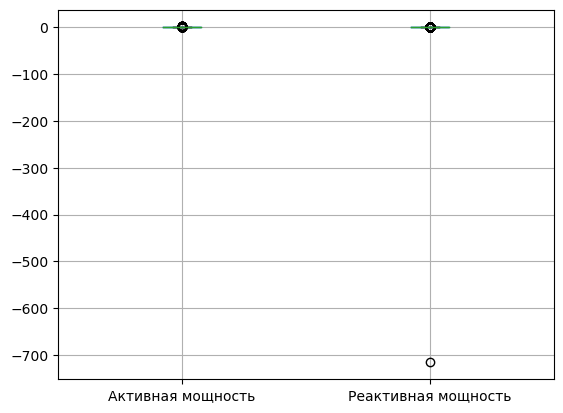

+++++++++++++++++++++++++++++++++


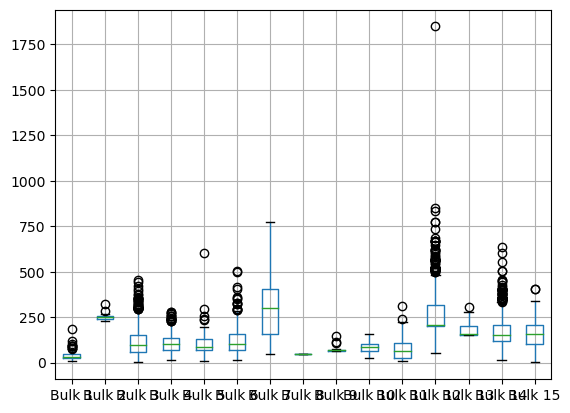

+++++++++++++++++++++++++++++++++


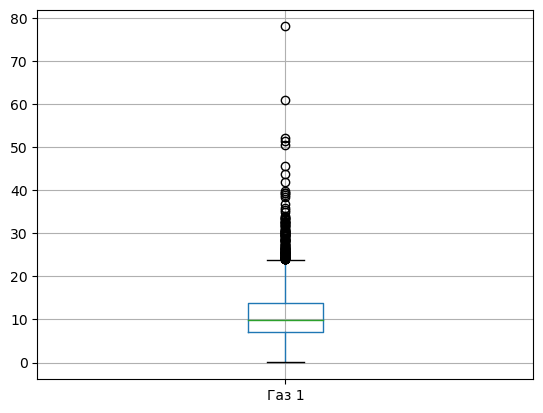

+++++++++++++++++++++++++++++++++


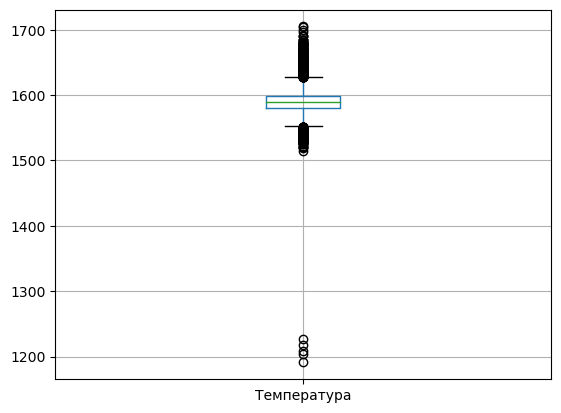

+++++++++++++++++++++++++++++++++


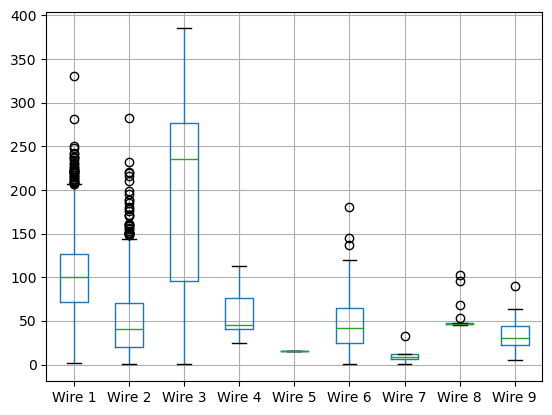

+++++++++++++++++++++++++++++++++


In [6]:
list_of_df_box = [electrod_df, supply_df, gas_df, temp_df, material_df]
for i in list_of_df_box:
    i = i.drop(columns='key')
    i.boxplot()
    plt.show()
    print('+++++++++++++++++++++++++++++++++')

Отдельно посмотрим боксплоты для мощбностей, тк из-за выброса не было видно нормально

In [7]:
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(electrod_df[['Реактивная мощность', 'Активная мощность']],\
            labels=['Reactiv', 'Active'], vert=True, patch_artist=True  )
plt.ylim(2, -2);

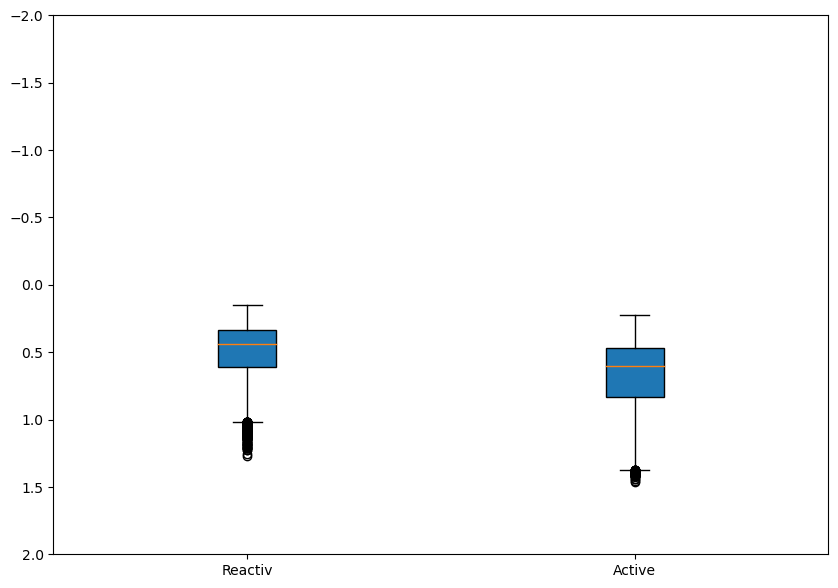

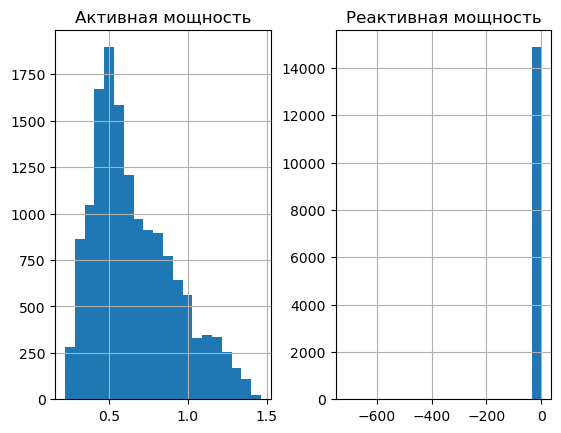

+++++++++++++++++++++++++++++++++


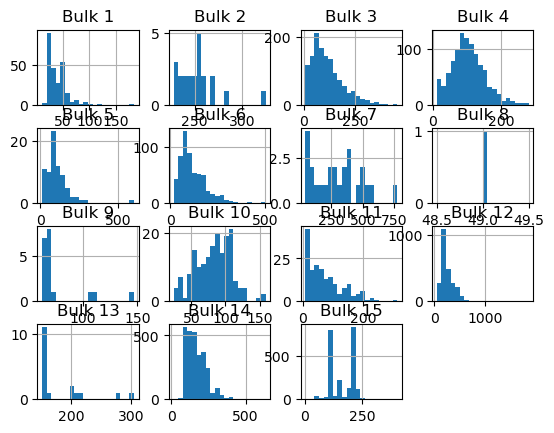

+++++++++++++++++++++++++++++++++


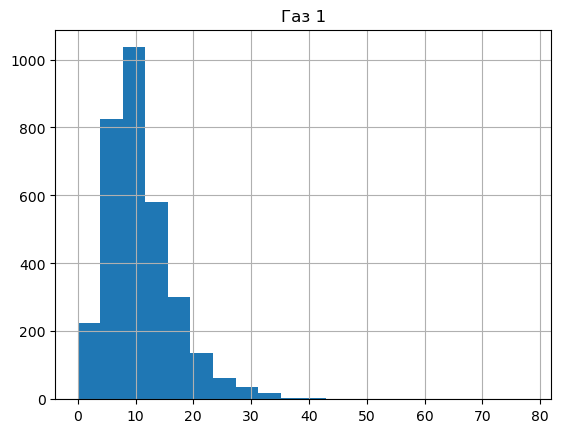

+++++++++++++++++++++++++++++++++


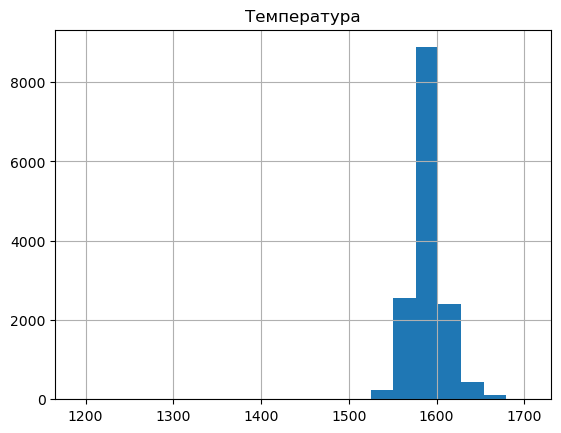

+++++++++++++++++++++++++++++++++


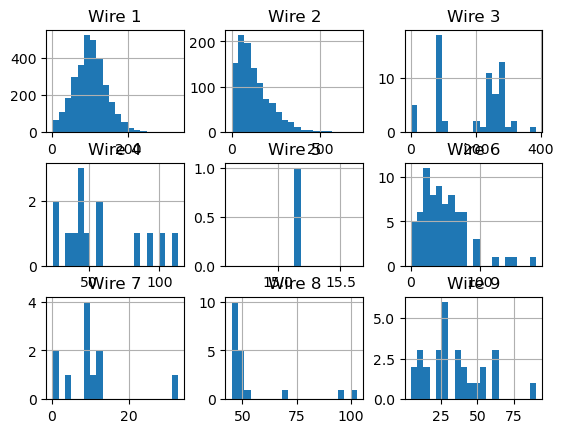

+++++++++++++++++++++++++++++++++


In [8]:
for i in list_of_df_box:
    i = i.drop(columns='key')
    i.hist(bins=20)
    plt.show()
    print('+++++++++++++++++++++++++++++++++')

Отдельно посмотрим гистограмму температуры и увеличим количкство бимов, тк это целевой признак

In [9]:
plt.hist(temp_df['Температура'], bins=100)
plt.xlabel('Temp')
plt.ylabel('count')
plt.title('Гистограмма измерений температуры');

In [10]:
plt.hist(gas_df['Газ 1'], bins=100)
plt.xlabel('Gas')
plt.ylabel('count')
plt.title('Гистограмма добавления газа');

## Вывод

1. После предворительного изучения данных необходимо:
- переименовать колонки в датафреймах
- изменить тип данных с object на datetime
- после обединения удалить все строки с пропусками в таблицы с целивыми данными температуры (data_temp)
2. Так же после построения графиков:
- в неторорых данных есть очень большие выбросы как например в реакртивной мощности, что с такими делать? удалить?
    - может ли быть реактивная мощность быть меньше 0? кажется нет
- так же очень много пропусков в некоторых таблицах, что с ними делать? 
- по боксплотам видно, что очень много выбросов, что тоже не очень хорошо, стоит ли удалять выбросы?

# Предобработка 

## Исправление названия колонок

In [11]:
for col in list_of_df:
    print (*col.columns)
    print()

key Начало нагрева дугой Конец нагрева дугой Активная мощность Реактивная мощность

key Bulk 1 Bulk 2 Bulk 3 Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15

key Bulk 1 Bulk 2 Bulk 3 Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15

key Газ 1

key Время замера Температура

key Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9

key Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9



In [12]:
electrod_df.rename(columns={'Начало нагрева дугой' : 'start_heating', 'Конец нагрева дугой' : 'end_heating'\
       ,'Активная мощность' : 'active_power', 'Реактивная мощность' : 'reactive_power'}, inplace=True)

supply_df.rename(columns={'Bulk 1' : 'bulk_1', 'Bulk 2' : 'bulk_2', 'Bulk 3' : 'bulk_3', 'Bulk 4' : 'bulk_4'\
                          , 'Bulk 5' : 'bulk_5', 'Bulk 6' : 'bulk_6','Bulk 7' : 'bulk_7', 'Bulk 8' : 'bulk_8'\
                          , 'Bulk 9' : 'bulk_9', 'Bulk 10' : 'bulk_10', 'Bulk 11' : 'bulk_11', 'Bulk 12' : 'bulk_12'\
                          ,'Bulk 13' : 'bulk_13', 'Bulk 14' : 'bulk_14', 'Bulk 15' : 'bulk_15'}, inplace=True)

sypply_time_df.rename(columns={'Bulk 1' : 'bulk_1', 'Bulk 2' : 'bulk_2', 'Bulk 3' : 'bulk_3', 'Bulk 4' : 'bulk_4'\
                          , 'Bulk 5' : 'bulk_5', 'Bulk 6' : 'bulk_6','Bulk 7' : 'bulk_7', 'Bulk 8' : 'bulk_8'\
                          , 'Bulk 9' : 'bulk_9', 'Bulk 10' : 'bulk_10', 'Bulk 11' : 'bulk_11', 'Bulk 12' : 'bulk_12'\
                          ,'Bulk 13' : 'bulk_13', 'Bulk 14' : 'bulk_14', 'Bulk 15' : 'bulk_15'}, inplace=True)
   
gas_df.rename(columns={'Газ 1' : 'gas'}, inplace=True)

temp_df.rename(columns={'Время замера' : 'measure_time', 'Температура' : 'temperature'}, inplace=True)

material_df.rename(columns={'Wire 1' : 'wire_1', 'Wire 2' : 'wire_2', 'Wire 3' : 'wire_3'\
                            , 'Wire 4' : 'wire_4', 'Wire 5' : 'wire_5', 'Wire 6' : 'wire_6'\
                            , 'Wire 7' : 'wire_7', 'Wire 8' : 'wire_8', 'Wire 9' : 'wire_9'}, inplace=True)

material_time_df.rename(columns={'Wire 1' : 'wire_1', 'Wire 2' : 'wire_2', 'Wire 3' : 'wire_3'\
                            , 'Wire 4' : 'wire_4', 'Wire 5' : 'wire_5', 'Wire 6' : 'wire_6'\
                            , 'Wire 7' : 'wire_7', 'Wire 8' : 'wire_8', 'Wire 9' : 'wire_9'}, inplace=True)

In [13]:
for col in list_of_df:
    print(*col.columns)
    print()

key start_heating end_heating active_power reactive_power

key bulk_1 bulk_2 bulk_3 bulk_4 bulk_5 bulk_6 bulk_7 bulk_8 bulk_9 bulk_10 bulk_11 bulk_12 bulk_13 bulk_14 bulk_15

key bulk_1 bulk_2 bulk_3 bulk_4 bulk_5 bulk_6 bulk_7 bulk_8 bulk_9 bulk_10 bulk_11 bulk_12 bulk_13 bulk_14 bulk_15

key gas

key measure_time temperature

key wire_1 wire_2 wire_3 wire_4 wire_5 wire_6 wire_7 wire_8 wire_9

key wire_1 wire_2 wire_3 wire_4 wire_5 wire_6 wire_7 wire_8 wire_9



## Работа с пропусками

In [14]:
supply_df.fillna(0, inplace=True)

material_df.fillna(0, inplace=True)

In [15]:
temp_df['temperature'].dropna(inplace=True)

In [16]:
print(electrod_df.shape)
electrod_df = electrod_df[electrod_df['reactive_power'] >= 0]
print(electrod_df.shape)

(14876, 5)
(14875, 5)


In [17]:
print(temp_df.shape)
temp_df[temp_df['temperature'] >= 1400]
print(temp_df.shape)

(18092, 3)
(18092, 3)


In [18]:
temp_df.dropna(subset=['temperature'], inplace=True)
temp_df.shape

(14665, 3)

In [19]:
sypply_time_df.fillna('no info', inplace=True)
material_time_df.fillna('no info', inplace=True)

In [20]:
for num, df in enumerate(list_of_df):
    if df.isna().values.any():
        display(pd.DataFrame(df.isna().mean().to_frame(name='na')).style.format({'na':'{:.2%}'}))
    else: print(num)

0
1
2
3
4
5
6


## Отбераем только последнее значение при n ключе

In [21]:
temp_df[temp_df.groupby('key')['key'].transform('size') == 1]

,key,measure_time,temperature
1105,195,2019-05-11 00:01:36,1583.0
1549,279,2019-05-14 10:13:01,1603.0
13926,2500,2019-08-10 14:04:39,1539.0
13931,2501,2019-08-10 14:41:14,1587.0
13938,2502,2019-08-10 15:39:39,1583.0
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.0
18067,3238,2019-09-06 12:16:15,1584.0
18071,3239,2019-09-06 14:16:50,1598.0
18080,3240,2019-09-06 15:25:21,1617.0


In [22]:
%%time
new_temp_df = pd.DataFrame(columns=['key', 'measure_time', 'temperature'])
for key in temp_df.key.unique():
    if temp_df[temp_df['key'] == key]['key'].count() > 2:
        val = temp_df[temp_df['measure_time'] == temp_df[temp_df['key'] == key]['measure_time'].max()]
        new_temp_df = pd.concat([new_temp_df, val], ignore_index=True)
print(new_temp_df.shape)
new_temp_df.head()

(2443, 3)
CPU times: user 3.22 s, sys: 13.7 ms, total: 3.23 s
Wall time: 3.23 s


,key,measure_time,temperature
0,1,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:36:39,1602.0


In [23]:
data_target = temp_df.groupby(by = 'key', as_index = False).agg(['first', 'last'])
data_target.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']
data_target.reset_index(inplace=True)
data_target.drop(columns=['time_first', 'time_last', 'temp_last'], inplace=True)
data_target.head()


,key,temp_first
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


проверил наличее таких записей, взял в пример key = 3000

In [24]:
new_temp_df[new_temp_df['key'] == 3000]

,key,measure_time,temperature


## Создание колонки сколько по нагреву при итерации

In [25]:
electrod_df['end_heating'] = pd.to_datetime(electrod_df['end_heating'])
electrod_df['start_heating'] = pd.to_datetime(electrod_df['start_heating'])
electrod_df['heating_time'] = electrod_df['end_heating'] - electrod_df['start_heating']
electrod_df.head(10)

,key,start_heating,end_heating,active_power,reactive_power,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0 days 00:02:17
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,0 days 00:05:38
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,0 days 00:02:06
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,0 days 00:03:30
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,0 days 00:04:40


## Создадим сводную таблицу с нужными значениями в колонках

создали колонки с суммой потраченных энергий и времени

In [26]:
new_electrod_df = electrod_df.pivot_table(index='key'
                               , values=['start_heating'
                                                    , 'end_heating'
                                                    , 'active_power'
                                                    , 'reactive_power'
                                                    , 'heating_time']
                              , aggfunc={'start_heating' : 'min'
                                        , "end_heating" : 'max'
                                        , "active_power" : 'sum'
                                        , 'reactive_power' : 'sum'
                                        , 'heating_time' : 'sum'})
new_electrod_df.reset_index(inplace=True)
new_electrod_df['heating_time'] = new_electrod_df['heating_time'].dt.seconds
new_electrod_df.head()

,key,active_power,end_heating,heating_time,reactive_power,start_heating
0,1,3.036730,2019-05-03 11:28:37,1098,2.142821,2019-05-03 11:02:14
1,2,2.139408,2019-05-03 11:53:18,811,1.453357,2019-05-03 11:34:14
2,3,4.063641,2019-05-03 12:32:19,655,2.937457,2019-05-03 12:06:54
3,4,2.706489,2019-05-03 12:57:50,741,2.056992,2019-05-03 12:39:37
4,5,2.252950,2019-05-03 13:33:55,869,1.687991,2019-05-03 13:11:13


## Оставмли только нужные по моему мнению датасеты

In [28]:
data_frames =[new_temp_df ,new_electrod_df, supply_df, gas_df, material_df]

In [29]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['key'],
                                            how='left'), data_frames)

In [30]:
df_merged = df_merged.merge(data_target,on=['key'],how='left')

In [31]:
df_info(df_merged)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Дубликатов нет - False
-------------------------------------------------------------
Процент пропусков в таблице


,na
key,0.00%
measure_time,0.00%
temperature,0.00%
active_power,0.00%
end_heating,0.00%
heating_time,0.00%
reactive_power,0.00%
start_heating,0.00%
bulk_1,2.50%
bulk_2,2.50%


-------------------------------------------------------------
Размер таблицы -  (2443, 34)
-------------------------------------------------------------
Информация про таблицу
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2443 entries, 0 to 2442
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             2443 non-null   object        
 1   measure_time    2443 non-null   object        
 2   temperature     2443 non-null   float64       
 3   active_power    2443 non-null   float64       
 4   end_heating     2443 non-null   datetime64[ns]
 5   heating_time    2443 non-null   int64         
 6   reactive_power  2443 non-null   float64       
 7   start_heating   2443 non-null   datetime64[ns]
 8   bulk_1          2382 non-null   float64       
 9   bulk_2          2382 non-null   float64       
 10  bulk_3          2382 non-null   float64       
 11  bulk_4          2382 non-null   floa

In [32]:
df_merged.dropna(inplace=True)
df_merged.isna().values.any()

False

уберем лишниее колонки

In [33]:
df_merged.drop(columns=['key', 'measure_time', 'start_heating', 'end_heating'], inplace=True)

создатим столбцы с расчетам полной работы и энергии

In [34]:
df_merged['apparent_power'] = np.sqrt(df_merged['active_power']**2 + df_merged['reactive_power']**2)
df_merged['full_work'] = df_merged.heating_time * df_merged.apparent_power

In [35]:
df_merged.dtypes

temperature       float64
active_power      float64
heating_time        int64
reactive_power    float64
bulk_1            float64
bulk_2            float64
bulk_3            float64
bulk_4            float64
bulk_5            float64
bulk_6            float64
bulk_7            float64
bulk_8            float64
bulk_9            float64
bulk_10           float64
bulk_11           float64
bulk_12           float64
bulk_13           float64
bulk_14           float64
bulk_15           float64
gas               float64
wire_1            float64
wire_2            float64
wire_3            float64
wire_4            float64
wire_5            float64
wire_6            float64
wire_7            float64
wire_8            float64
wire_9            float64
temp_first        float64
apparent_power    float64
full_work         float64
dtype: object

In [36]:
df_merged

,temperature,active_power,heating_time,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,temp_first,apparent_power,full_work
0,1613.0,3.036730,1098,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,3.716640,4080.870431
1,1602.0,2.139408,811,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,2.586371,2097.546600
2,1599.0,4.063641,655,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,5.014163,3284.276844
3,1625.0,2.706489,741,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,3.399456,2518.996645
4,1602.0,2.252950,869,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,2.815155,2446.369640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,1591.0,3.168133,723,2.210936,0.0,0.0,21.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,3.863328,2793.186281
2439,1591.0,4.174918,940,2.872031,0.0,0.0,0.0,63.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0,5.067396,4763.352254
2440,1589.0,3.605239,569,2.452092,0.0,0.0,0.0,85.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,4.360104,2480.898950
2441,1594.0,3.202310,750,2.239820,0.0,0.0,90.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,3.907887,2930.915458


## Матрица корреляции

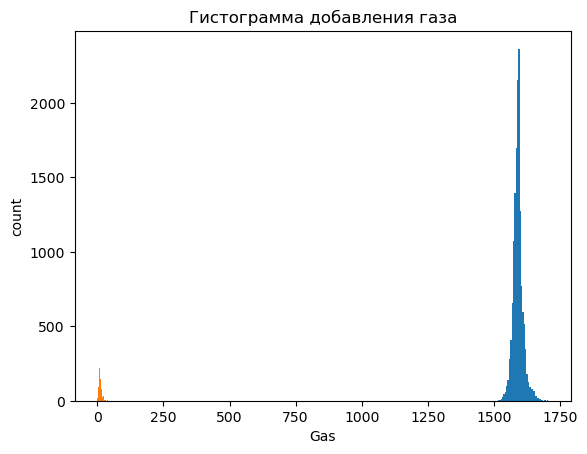

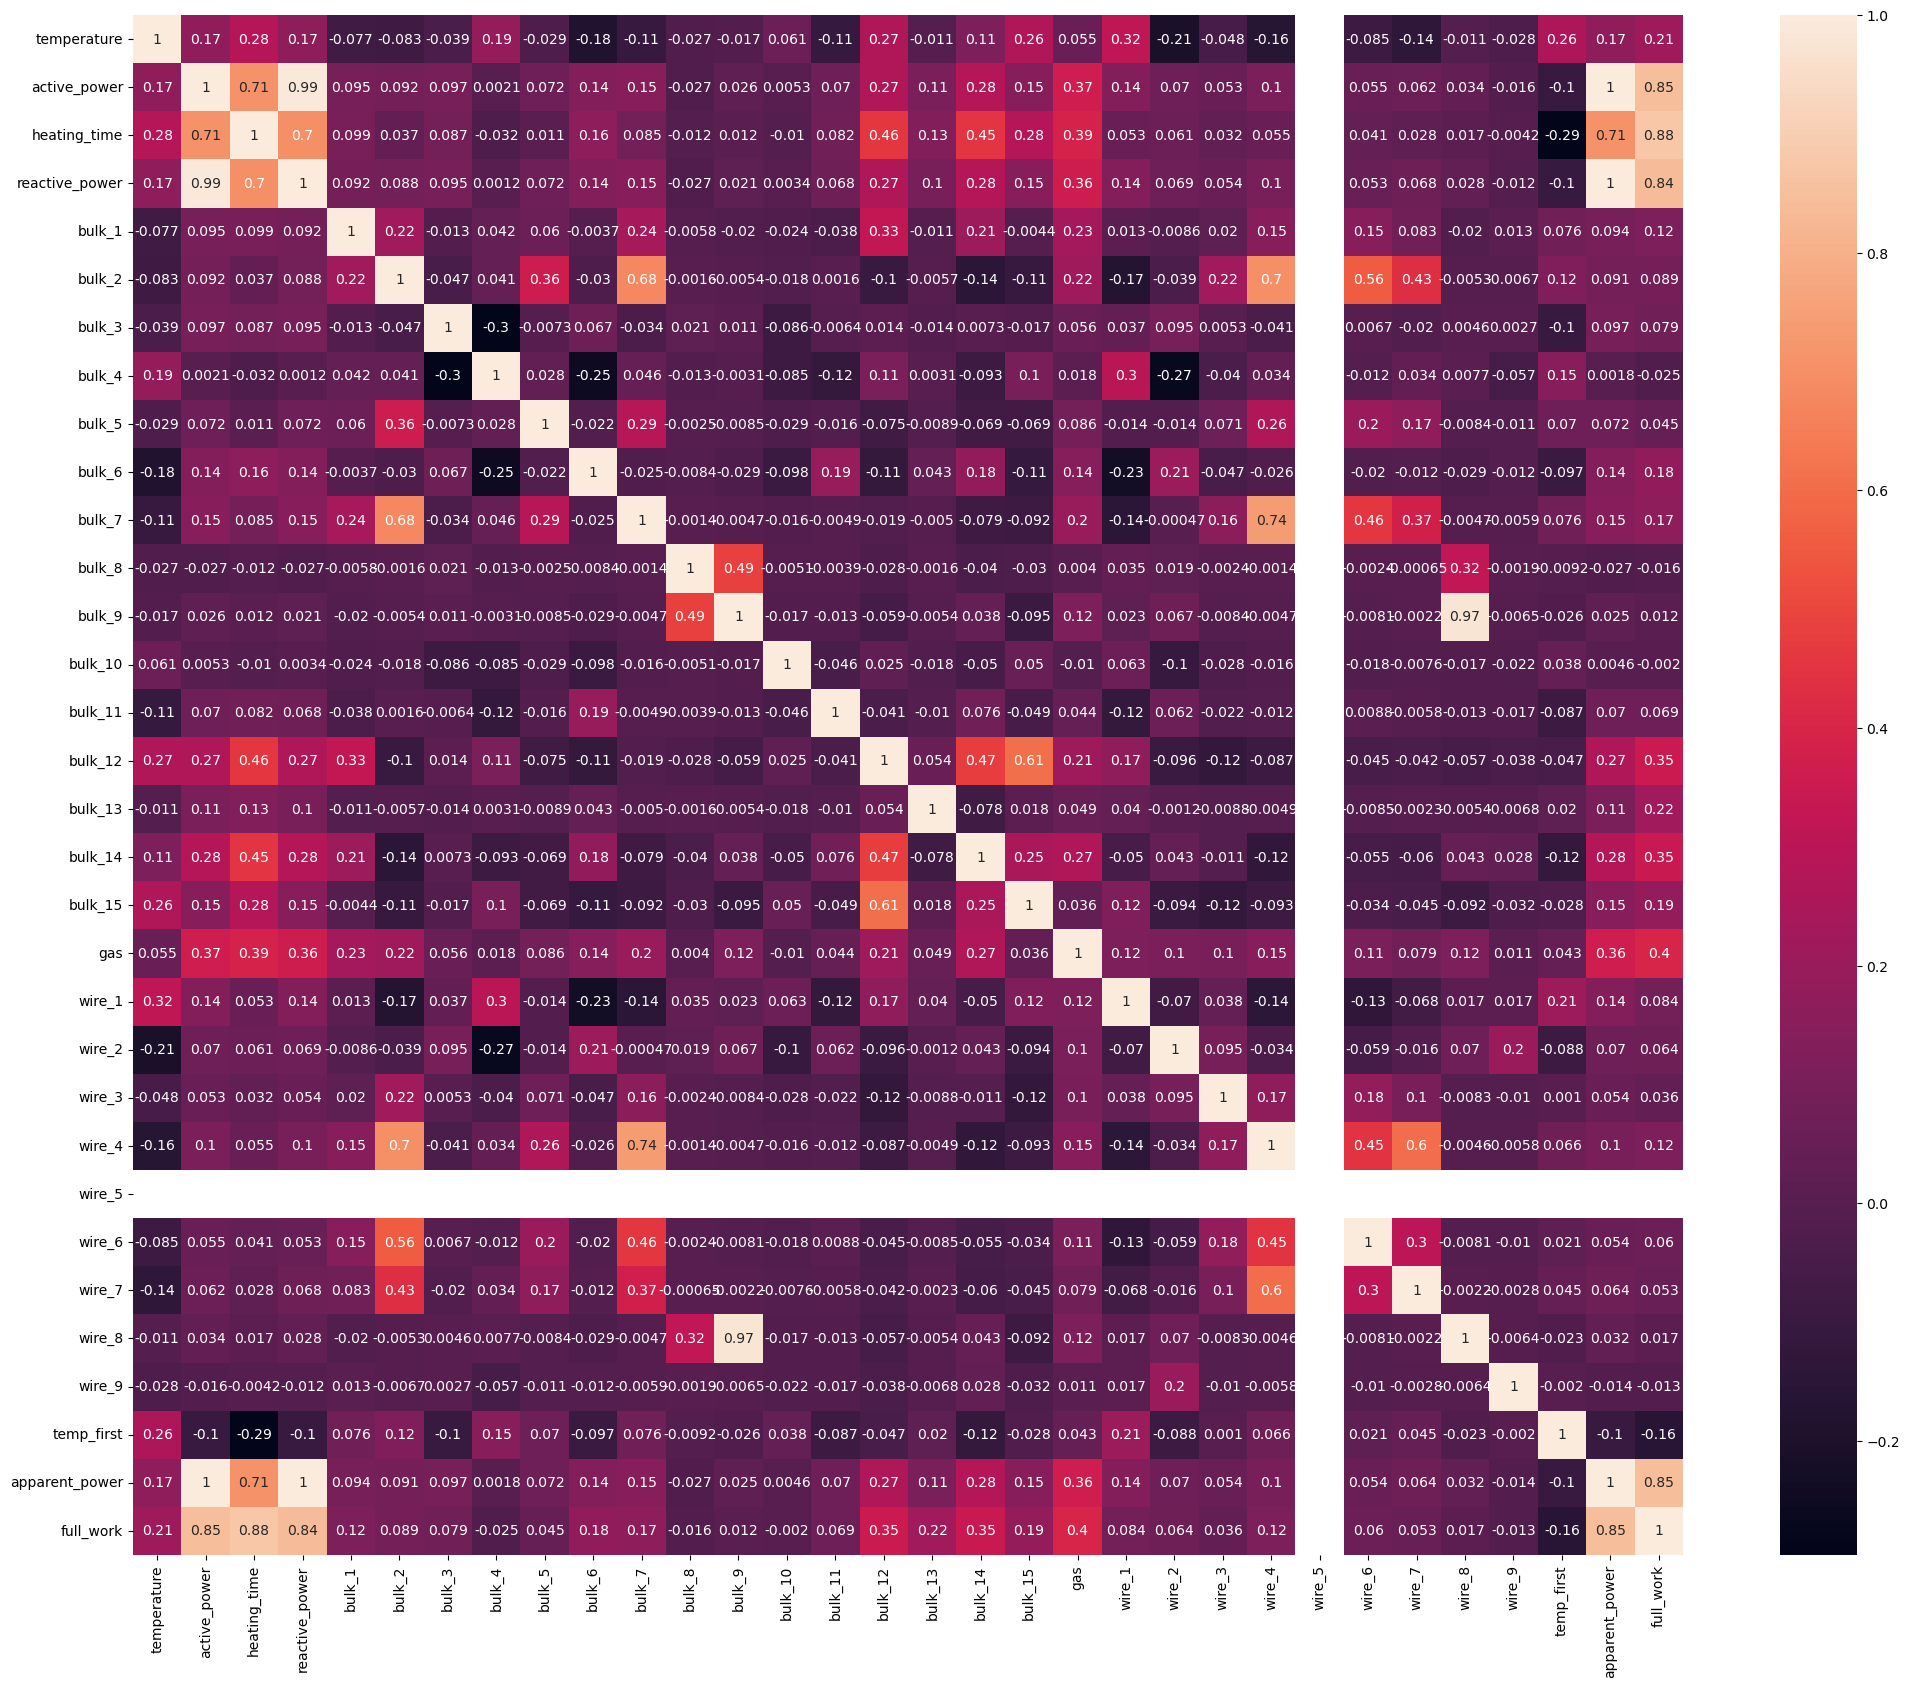

In [37]:
m, kk = plt.subplots(figsize=(25, 20))
sns.heatmap(df_merged.corr(), annot=True)
plt.show()

## Посмотрим важность колонок

In [38]:
X = df_merged.drop(columns=['temperature', 'active_power', 'reactive_power', 'wire_8', 'wire_5'])
y = df_merged.temperature
X.head()

,heating_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,temp_first,apparent_power,full_work
0,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,1571.0,3.716640,4080.870431
1,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,1581.0,2.586371,2097.546600
2,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,1596.0,5.014163,3284.276844
3,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,1601.0,3.399456,2518.996645
4,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,1576.0,2.815155,2446.369640


In [39]:
X

,heating_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,temp_first,apparent_power,full_work
0,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,1571.0,3.716640,4080.870431
1,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,1581.0,2.586371,2097.546600
2,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,1596.0,5.014163,3284.276844
3,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,1601.0,3.399456,2518.996645
4,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,1576.0,2.815155,2446.369640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,723,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,1570.0,3.863328,2793.186281
2439,940,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,1554.0,5.067396,4763.352254
2440,569,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,1571.0,4.360104,2480.898950
2441,750,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,1591.0,3.907887,2930.915458


In [40]:
y

0       1613.0
1       1602.0
2       1599.0
3       1625.0
4       1602.0
         ...  
2438    1591.0
2439    1591.0
2440    1589.0
2441    1594.0
2442    1603.0
Name: temperature, Length: 2304, dtype: float64

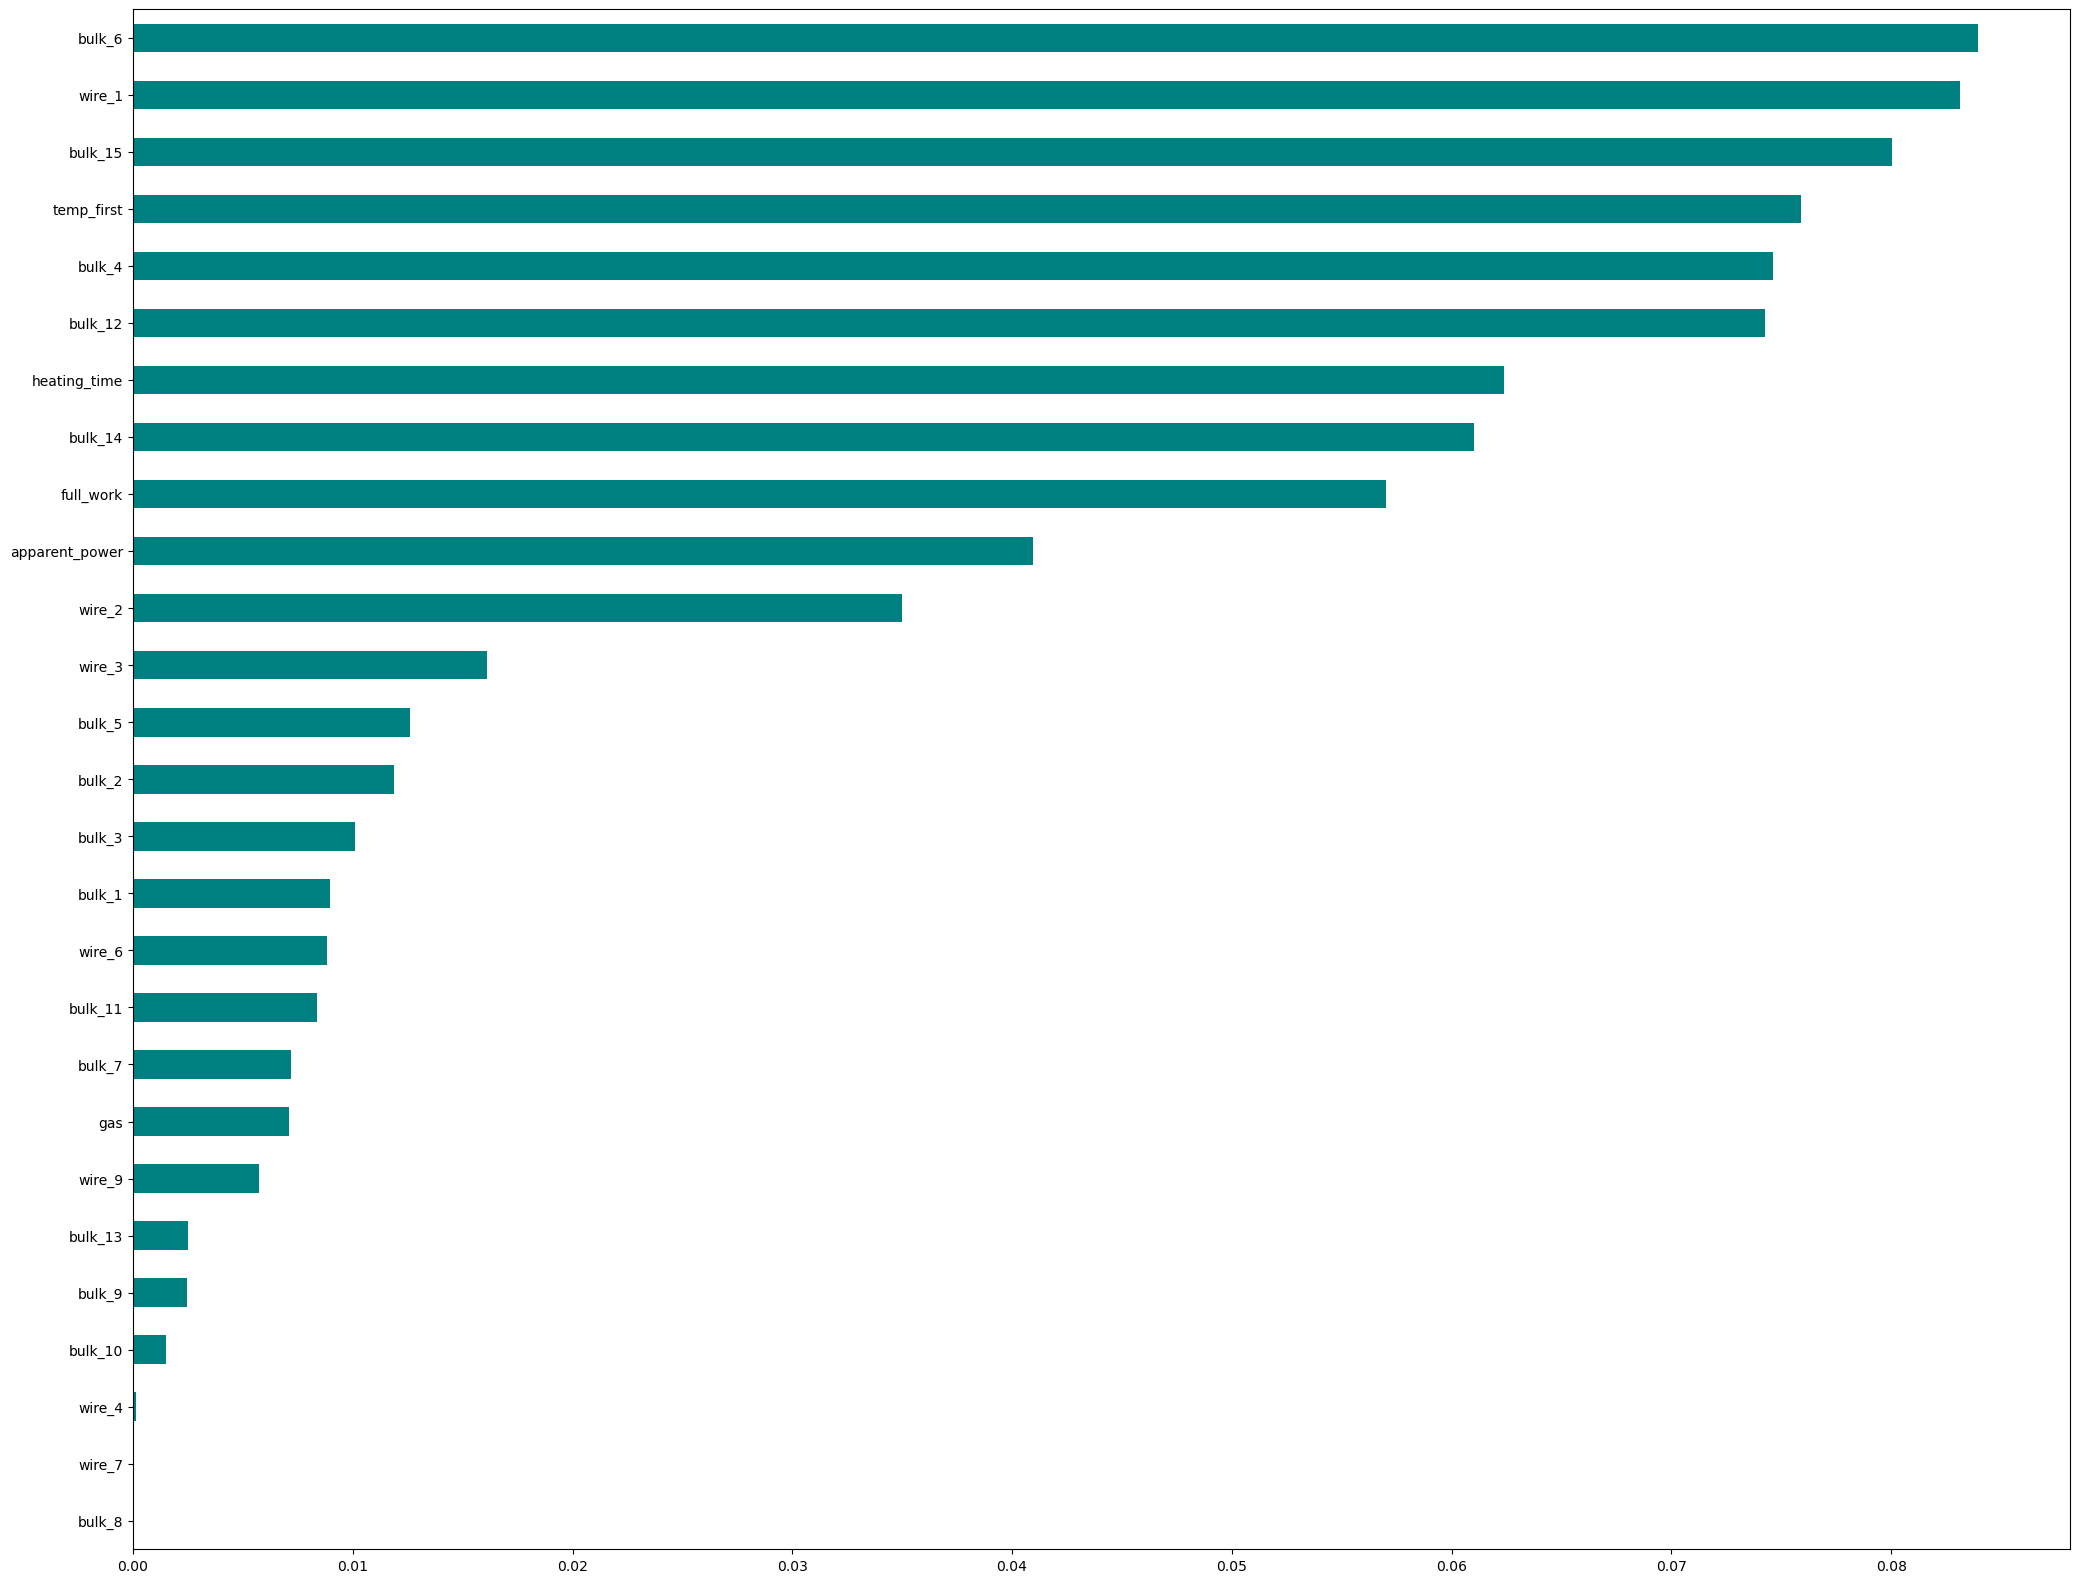

In [41]:
importances = mutual_info_regression(X=X, y=y, random_state=1234)
k, af = plt.subplots(figsize=(25, 20))
feature_importances = pd.Series(importances, X.columns).sort_values()
feature_importances.plot(kind='barh', color='teal')
plt.show()

In [42]:
valuable_features = list(feature_importances.sort_values(ascending=False).head(22).index)
valuable_features

['bulk_6',
 'wire_1',
 'bulk_15',
 'temp_first',
 'bulk_4',
 'bulk_12',
 'heating_time',
 'bulk_14',
 'full_work',
 'apparent_power',
 'wire_2',
 'wire_3',
 'bulk_5',
 'bulk_2',
 'bulk_3',
 'bulk_1',
 'wire_6',
 'bulk_11',
 'bulk_7',
 'gas',
 'wire_9',
 'bulk_13']

оставим только первые 13 тк они вносят больше всего пользы

# Обучение 

In [43]:
X_train,X_test,  y_train, y_test = train_test_split(X[valuable_features], y, test_size=0.3)
round(len(X_train) / len(X) * 100), round(len(y_train) / len(y) * 100)

(70, 70)

In [44]:
standart = StandardScaler()
standart.fit(X_train)

X_train = pd.DataFrame(standart.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(standart.transform(X_test), columns=X_train.columns)
display(X_train.head()) 
X_test.head()

,bulk_6,wire_1,bulk_15,temp_first,bulk_4,bulk_12,heating_time,bulk_14,full_work,apparent_power,...,bulk_5,bulk_2,bulk_3,bulk_1,wire_6,bulk_11,bulk_7,gas,wire_9,bulk_13
0,-0.394774,0.786798,1.262330,0.086431,-0.625551,2.188989,2.518858,0.588571,2.671594,2.125107,...,-0.119069,-0.074442,0.819401,-0.265014,-0.117574,-0.190052,-0.057712,0.708082,-0.090923,-0.0723
1,0.623486,0.544214,-0.219929,-0.087077,-0.625551,0.294104,0.056341,-0.032680,0.586185,1.676994,...,-0.119069,-0.074442,-0.651810,3.340729,-0.117574,-0.190052,-0.057712,2.061955,-0.090923,-0.0723
2,-0.394774,0.961369,-0.207878,1.127483,-0.625551,-0.363305,-0.649380,-0.159466,-0.755801,-1.253957,...,-0.119069,-0.074442,0.155403,1.851401,-0.117574,-0.190052,-0.057712,-0.401681,-0.090923,-0.0723
3,-0.394774,1.100781,-0.231980,-0.191182,-0.625551,-0.041046,-0.862598,-0.387680,-0.642896,-0.622195,...,-0.119069,-0.074442,0.038227,-0.265014,-0.117574,-0.190052,-0.057712,0.037553,-0.090923,-0.0723
4,-0.394774,-0.100827,1.033364,-0.434095,2.004907,-0.015265,-0.096815,-0.565180,-0.106321,0.132501,...,-0.119069,-0.074442,-0.651810,-0.265014,-0.117574,-0.190052,-0.057712,-0.675435,-0.090923,-0.0723


,bulk_6,wire_1,bulk_15,temp_first,bulk_4,bulk_12,heating_time,bulk_14,full_work,apparent_power,...,bulk_5,bulk_2,bulk_3,bulk_1,wire_6,bulk_11,bulk_7,gas,wire_9,bulk_13
0,-0.394774,-1.905328,-0.183776,-0.572901,-0.625551,-0.350415,-0.835571,-0.172144,-0.663933,-0.737597,...,-0.119069,-0.074442,-0.651810,-0.265014,-0.117574,-0.190052,-0.057712,-0.928944,-0.090923,-0.0723
1,-0.394774,0.405522,0.382616,0.919273,-0.625551,-0.034601,-1.147890,-0.045358,-0.687733,-0.389107,...,-0.119069,-0.074442,-0.404438,-0.265014,-0.117574,-0.190052,-0.057712,-0.845394,-0.090923,-0.0723
2,-0.394774,-0.055582,-1.461170,0.676361,-0.625551,-1.355864,-1.394142,-1.947147,-0.856759,-0.859359,...,-0.119069,-0.074442,0.298618,-0.265014,-0.117574,-0.190052,-0.057712,-0.627871,-0.090923,-0.0723
3,-0.394774,-0.055582,1.009262,-1.405743,-0.625551,2.949521,1.173483,0.563214,0.537695,0.256571,...,-0.119069,-0.074442,1.262066,2.164943,-0.117574,-0.190052,-0.057712,-1.178171,-0.090923,-0.0723
4,-0.394774,0.638236,1.045414,0.884571,-0.625551,1.299553,0.738038,1.222501,0.789639,1.144089,...,-0.119069,-0.074442,-0.651810,-0.265014,-0.117574,-0.190052,-0.057712,0.150269,-0.090923,-0.0723


In [45]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1612, 22), (1612,), (692, 22), (692,))

## LinearRegression

In [46]:
%%time

regressor = LinearRegression()

best_lr_score = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', best_lr_score)

Mean MAE from CV of LinearRegression = 6.43821149553955
CPU times: user 141 ms, sys: 25.5 ms, total: 167 ms
Wall time: 30.1 ms


## LGBMRegressor

In [47]:
%%time
pipe_lgbm = Pipeline([
    ('lgbm', LGBMRegressor(boosting_type='gbdt', random_state=12345))
    
])

# lgbm = LGBMRegressor(boosting_type='gbdt', random_state=12345)
params = {
    'lgbm__learning_rate': [x/100 for x in range(1, 11)],
    'lgbm__n_estimators': [40, 60],
    'lgbm__num_leaves': [x for x in range(4,31)]
}

gs_gbm =  RandomizedSearchCV(pipe_lgbm, params, cv=3, scoring='neg_mean_absolute_error', verbose=True)

model_random_gbm = gs_gbm.fit(X_train,y_train)

# random random search results
best_lgbm_params = model_random_gbm.best_params_
best_lgbm_score = -model_random_gbm.best_score_
print('Best random search hyperparameters are: '+str(best_lgbm_params))
print('Best random search score is: '+str(best_lgbm_score))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best random search hyperparameters are: {'lgbm__num_leaves': 14, 'lgbm__n_estimators': 40, 'lgbm__learning_rate': 0.1}
Best random search score is: 6.197029201022226
CPU times: user 8.39 s, sys: 1.39 s, total: 9.78 s
Wall time: 1.01 s


## CatBoostRegressor

In [48]:
%%time
cbr = CatBoostRegressor(random_seed=12345,
                        loss_function='RMSE',
                        silent=True)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [d for d in range(2, 11)],
}

cat =  RandomizedSearchCV(cbr, params, cv=3, scoring='neg_mean_absolute_error', verbose=True)

model_random_cat = cat.fit(X_train,y_train)

# random random search results
best_cbr_params = model_random_cat.best_params_
best_cbr_score = -model_random_cat.best_score_
print('Best random search hyperparameters are: '+str(best_cbr_params))
print('Best random search score is: '+str(best_cbr_score))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best random search hyperparameters are: {'learning_rate': 0.1778279410038923, 'iterations': 60, 'depth': 3}
Best random search score is: 6.141149269390191
CPU times: user 8.47 s, sys: 2.54 s, total: 11 s
Wall time: 2.12 s


## Ridge

In [49]:
%%time

pipe_ridge = Pipeline([
    
    ('model', Ridge(random_state=12345))
])

params = {'model__fit_intercept' : [True, False]
         , 'model__copy_X' : [True, False]
         , 'model__alpha': np.logspace(-2, 3, 20)
         }
rs_ridge = RandomizedSearchCV(pipe_ridge, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

model_random_ridge = rs_ridge.fit(X_train,y_train)

# random random search results
best_ridge_params = model_random_ridge.best_params_
best_ridge_score = -model_random_ridge.best_score_
print('Best random search hyperparameters are: '+str(best_ridge_params))
print('Best random search score is: '+str(best_ridge_score))

Best random search hyperparameters are: {'model__fit_intercept': True, 'model__copy_X': False, 'model__alpha': 14.38449888287663}
Best random search score is: 6.494047701284065
CPU times: user 76.4 ms, sys: 169 ms, total: 246 ms
Wall time: 1.53 s


## RandomForestRegressor

In [50]:
%%time

pipe_forest = Pipeline([
    ('model', RandomForestRegressor(random_state=12345))
])
params = [{'model__max_depth': [x for x in range(10, 100, 10)],
                'model__n_estimators':[x for x in range(50, 701, 50)], 
                'model__min_samples_split' : [2, 4, 6, 8]}]

rs_forest = RandomizedSearchCV(pipe_forest, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

model_random_forest = rs_forest.fit(X_train,y_train)

# random random search results
best_forest_params = model_random_forest.best_params_
best_forest_score = -model_random_forest.best_score_
print('Best random search hyperparameters are: '+str(best_forest_params))
print('Best random search score is: '+str(best_forest_score))

Best random search hyperparameters are: {'model__n_estimators': 600, 'model__min_samples_split': 8, 'model__max_depth': 30}
Best random search score is: 6.237216737571224
CPU times: user 4.75 s, sys: 181 ms, total: 4.93 s
Wall time: 13.3 s


In [51]:
pd.DataFrame((best_lr_score, best_ridge_score, best_lgbm_score, best_cbr_score, best_forest_score)
             , index=['LinearRegression', 'Ridge', 'LightGBM', 'CatBoost', 'RandomForest']
             , columns=['MAE'])

,MAE
LinearRegression,6.438211
Ridge,6.494048
LightGBM,6.197029
CatBoost,6.141149
RandomForest,6.237217


посмотрим результаты моделей и выделем 2 лучшие, для валидации их на тесте 

## Обучение лучших моделей и проверки их на тесте

In [52]:
best_lgbm_params

{'lgbm__num_leaves': 14, 'lgbm__n_estimators': 40, 'lgbm__learning_rate': 0.1}

In [56]:
best_model_lgbm = LGBMRegressor(random_state=12345, num_leaves=14, n_estimators=40, learning_rate=0.1)

best_model_lgbm.fit(X_train, y_train)
score_lgbm = mean_absolute_error(y_test, best_model_lgbm.predict(X_test))
score_lgbm

6.640138385687183

/Users/petrsilov/opt/anaconda3/envs/NLP_project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/petrsilov/opt/anaconda3/envs/NLP_project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/petrsilov/opt/anaconda3/envs/NLP_project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/petrsilov/opt/anaconda3/envs/NLP_project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <

In [54]:
importances = best_model_lgbm.feature_importances_
feature_list = list(X_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,temp_first,137
1,heating_time,115
2,wire_2,37
3,wire_1,33
4,bulk_1,28
5,bulk_14,27
6,bulk_6,24
7,bulk_15,20
8,gas,16
9,bulk_12,14


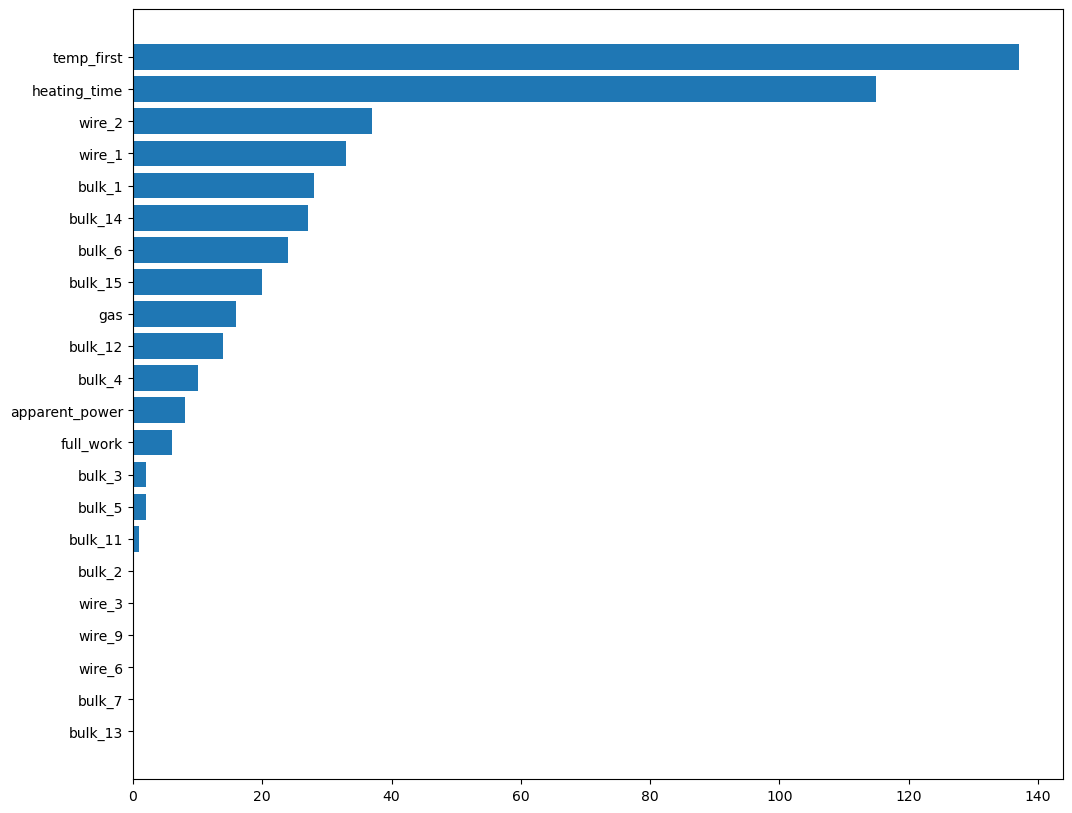

In [55]:
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])
plt.show()

модели показали не плохой результат на тестовых данных

такие значение когда добавяем первую температуру

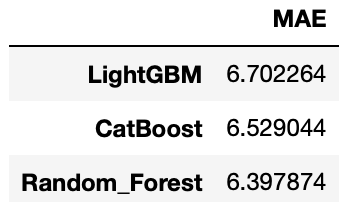

такие значение когда добавяем не первую температуру

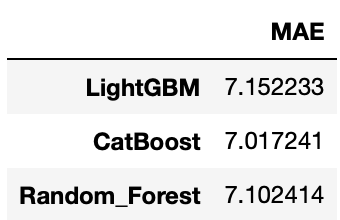

**По итогу было выполнено:**

1. Выстроен план работы

2. Изучены и подготовлены данные

3. На основе изученных данных стало понятно, что это задача регрессии

4. Далее мы предобработали данные, привели их в порядок, поработали с пропусками

5. Согласно физическам формуле начали считать полную мощность и работу

6. По итогу преобработанных данных начали формировать финальный датасет, проверив мультиколлинеарность

7. По колрреляционной матрице выявили факторы для удаления из таблицы 

8. Построили график актуальности параметров

9. Создали обучающую и тестовую выборку для моделей с использованием масштабирования

10. Обучили такие регрессионные модели как: Linear, RandomForest, CatBoost, LGBM, Ridge (с поиском лучших гиперпараметров)

11. Запустили тестирование моделей на тест данных для лучших моделей 

12. Вывели итоговые значения качества моделей CatBoostRegressor и LGBMRegressor

**Вывод**

В ходе работы были обучены такие регрессионные модели как: Linear, RandomForest, CatBoost, LGBM, Ridge.

Лучшей моделью оказалась CatBoostRegressor = 7.14 и LGBMRegressor = 6.9748 прогноза.

Основной проблемой можно назвать качество и бизнес адекватность данных,
очень много пропусков, не соответсвие принципу замер - добавки/продувки - замер.

# Отчет 

Стояла задача построить модель, которая предскажет последнюю измеренную температуру стали. В будующем такая модель должна помочь оптимизировать затраты на потребления электроэнергии на этапе обработки стали.
В рамках проектной работы был проведен анализ данных и составили план работы для получения удовлетворяющих результатов: 
1. Подготовка и анализ данных 
2. Предобработка данных 
3. Обучение моделей 
4. Вывод

1. Первым этапами работы являются:

- Импортировал необходимые библиотеки
- Загрузил датасеты
- Провел первичный осмотр каждого датасета
- Определял пропуски и дубликаты, рассмотрел варианты решения данной проблемы
- Проверили данные на аномальность и выбросы

2. После чего провел предобрабртку данных:

- Заполнил пропуски по выбранным гепотизам
- Изменил формат данных в некоторых столбцах для адекватной работы с ними в будещем
- Убрал объекты, которые не подходят для обучения
- Проверил признаки на мультиколлиниарность и удалили сильно коррелирующие
- Проверил признаки на важность для моделирования


3. Подготовили датасет для обучения:

- Определил целевой признак
- Создал новые признаки, которые по моему мнению несут больше информации для модели
- Поделили датасет на выборки: Обучающаю и тестовую
- Масштабировал количественные признаки для выборок
- Выбрал модели для работы: LinearRegression, RandomForest, LGBMRegression, Ridge, CatBoostRegressor
- Подобрал лучшие гиперпараметры для каждой модели 
- Сравнил результаты по метрике MAE
- Взял лучшую модель, а именно LGBMRegression для проверки на тесте
- Определили важность признаков для лучшей модели
- Вывести лучший результат LGBMRegressor МАЕ: 6.64

4. Вывод

1. Все пункты заплпнированного плана были успешно выполнены
2. Во время работы станкнулся с такими трудностями как:
    - не качественные данные на вход(много пропусков информации)
    - отпредление целевого признака(так же во входных данных можно было сразу его выделить)
    - формирование финального датасета
- Для их решения: 
    - пришлось заполнить большое количество данных искуственно 0 и удалить некоторые данные, что бы не мешать обучению
    - написал код для отбора только последней температуры ковша - что и есть целевой признак
    - придемал новые признаки подходящие для модели
3. Ключевые шаги представил выше

4. По идтогам поиска на траейн данных лучшая модель оказалась LGBMRegressor. После проверки на тестовом датачете  МАЕ показала значение 6.7

- Список признаков
    - 'bulk_6',
    - 'wire_1',
    - 'bulk_15',
    - 'temp_first',
    - 'bulk_4',
    - 'bulk_12',
    - 'heating_time',
    - 'bulk_14',
    - 'full_work',
    - 'apparent_power',
    - 'wire_2',
    - 'wire_3',
    - 'bulk_5',
    - 'bulk_2',
    - 'bulk_3',
    - 'bulk_1',
    - 'wire_6',
    - 'bulk_11',
    - 'bulk_7',
    - 'gas',
    - 'wire_9',
    - 'bulk_13'
    
после определения больше всего подходящих признаков, оставил 22 
и так же прикладываю важность признаков

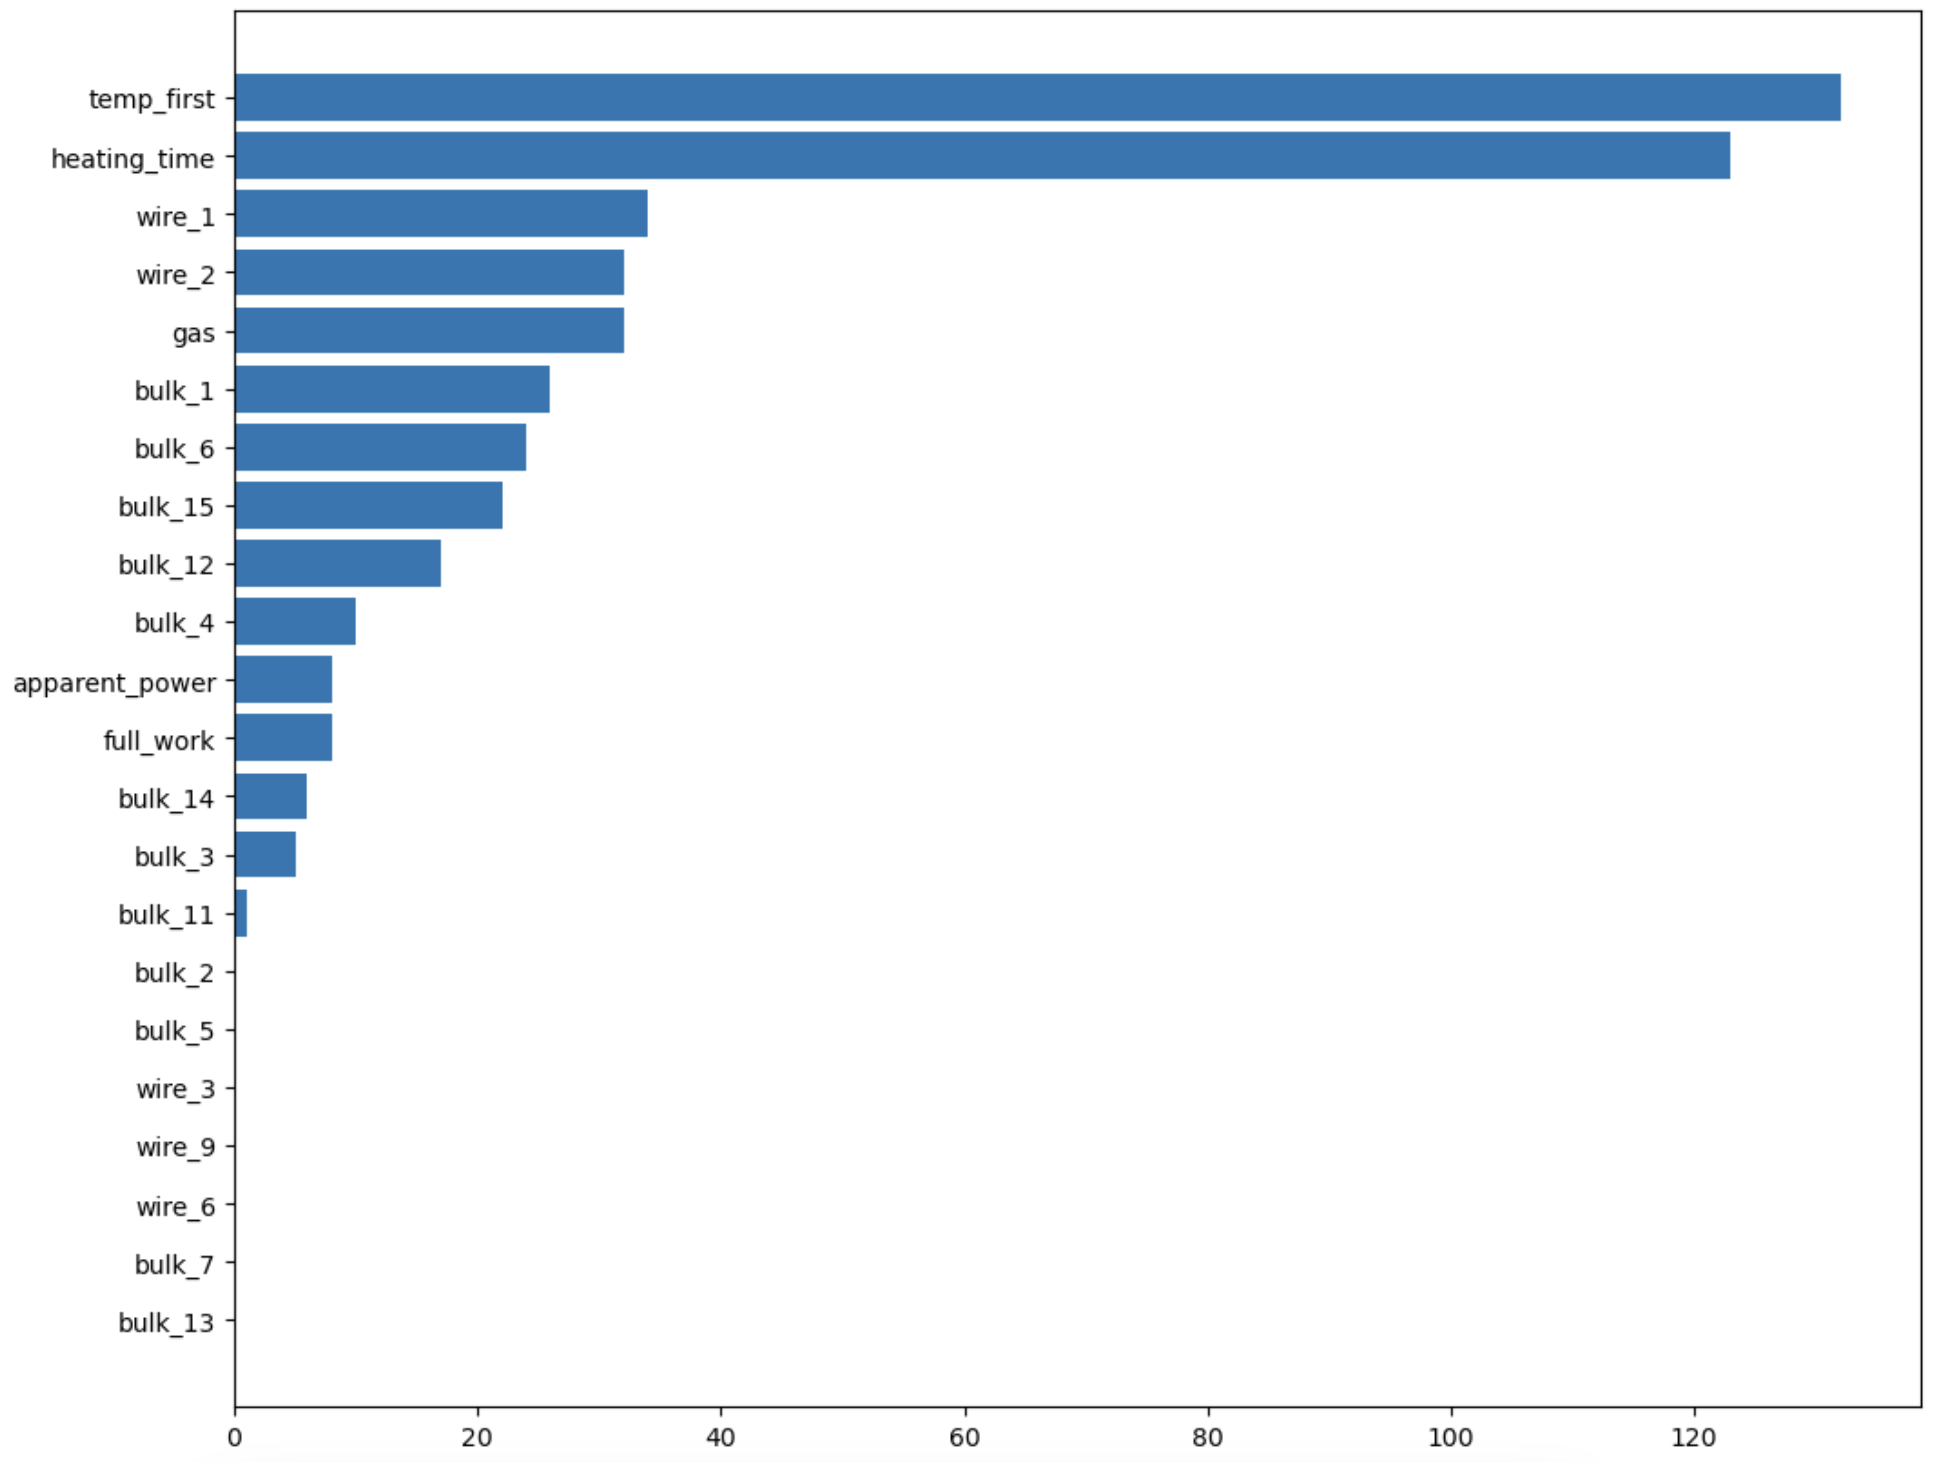

- Лучшие гиперпараметры и их значения:
    - random_state=12345
    - num_leaves=14 
    - n_estimators=40
    - learning_rate=0.1

- Для учешения модели я бы посоветовал:
    - более качественно заолнять начальные данные
    - описать данные, например некоторые присадки могут быть тугоплавкими и сильно влиять на процесс
    - можно точее подобрать гиперпараметры, если позваляеть вычеслительная техника
    - придумать еще признаков